# Assignment 6 Niveditha Achanta

In this assignment, you'll analyze a collection of data sets from the [San Francisco Open Data Portal](http://data.sfgov.org/) and [Zillow](https://www.zillow.com/). The data sets have been stored in the SQLite database `sf_data.sqlite`, which you can [download here](http://anson.ucdavis.edu/~nulle/sf_data.sqlite). The database contains the following tables:

Table                   | Description
----------------------- | -----------
`crime`                 | Crime reports dating back to 2010.
`mobile_food_locations` | List of all locations where mobile food vendors sell.
`mobile_food_permits`   | List of all mobile food vendor permits. More details [here](https://data.sfgov.org/api/views/rqzj-sfat/files/8g2f5RV4PEk0_b24iJEtgEet9gnh_eA27GlqoOjjK4k?download=true&filename=DPW_DataDictionary_Mobile-Food-Facility-Permit.pdf).
`mobile_food_schedule`  | Schedules for mobile food vendors.
`noise`                 | Noise complaints dating back to August 2015.
`parking`               | List of all parking lots.
`parks`                 | List of all parks.
`schools`               | List of all schools.
`zillow`                | Zillow rent and housing statistics dating back to 1996. More details [here](https://www.zillow.com/research/data/).

The `mobile_food_` tables are explicitly connected through the `locationid` and `permit` columns. The other tables are not connected, but you may be able to connect them using dates, latitude/longitude, or postal codes.

Shapefiles for US postal codes are available [here](https://www.census.gov/geo/maps-data/data/cbf/cbf_zcta.html). These may be useful for converting latitude/longitude to postal codes.

Shapefiles for San Francisco Neighborhoods are available [here](https://data.sfgov.org/Geographic-Locations-and-Boundaries/SF-Find-Neighborhoods/pty2-tcw4).

In [3]:
#LIBRARIES
    
import pandas as pd
from matplotlib import pyplot as plt
import sqlalchemy as sqla
import sqlite3 as sql
from mpl_toolkits.basemap import Basemap
import geopandas as gpd
import shapely.geometry as geom
import numpy as np
import seaborn as sns
import re
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 12)
plt.style.use('ggplot')

In [4]:
db = sql.connect("sf_data.sqlite") #Connect the database

__Exercise 1.1.__ Which mobile food vendor(s) sells at the most locations?

**Strategy**: First, I wanted to see what information each of the mobile_food tables to know a little more about what we're doing. After that, I wrote a SQL query that just contained the relevant information, put it into a dataframe, and used Pandas to count and order the values to see which food truck sold at the most number of locations. This gave us Park's Catering, with 22 locations, as shown below.

In [5]:
#pd.read_sql("SELECT * FROM mobile_food_permits", db).head()
#pd.read_sql("SELECT * FROM mobile_food_locations", db).head()
#pd.read_sql("SELECT * FROM mobile_food_schedule", db).head()

In [6]:
#Do 3 inner joins for the 3 relevant tables listed above
#pd.read_sql("SELECT * FROM mobile_food_permits", db)
df = pd.read_sql("SELECT mobile_food_locations.Address, mobile_food_permits.Applicant, count(*) \
FROM mobile_food_locations \
INNER JOIN mobile_food_schedule \
ON mobile_food_locations.locationid = mobile_food_schedule.locationid \
INNER JOIN mobile_food_permits \
ON mobile_food_permits.permit = mobile_food_schedule.permit \
WHERE status=='APPROVED' \
GROUP BY Address \
ORDER BY count(*) \
", db)
df['Applicant'].value_counts().head() #Counts the values 

Park's Catering    22
D & T Catering     17
F & C Catering     13
Munch A Bunch       9
Eva's Catering      8
Name: Applicant, dtype: int64

__Exercise 1.2.__ Ask and use the database to analyze 5 questions about San Francisco. For each question, write at least 150 words and support your answer with plots. Make a map for at least 2 of the 5 questions.

You should try to come up with some questions on your own, but these are examples of reasonable questions:

* Which parts of the city are the most and least expensive?
* Which parts of the city are the most dangerous (and at what times)?
* Are noise complaints and mobile food vendors related?
* What are the best times and places to find food trucks?
* Is there a relationship between housing prices and any of the other tables?

Please make sure to clearly state each of your questions in your submission.

**Problem 1: Which parts of the city are most and least expensive?**

The homes with the lowest median selling price per sqft were in 94134, 94124, and 94158. This corresponds to Visitation Valley, Hunters Point, and Mission Bay. From what I know about San Francisco (which is quite a lot, having grown up in the SF Bay Area), the first two are not very surprising, but it is interesting that Mission Bay makes the list since it is not considered a high crime area (this will be explained later in the assignment, but for now, it's simply just a well-known characteristic of San Francisco). One logical explanation for this is that developments in Mission Bay are just starting to burgeon, and it shares geographical overlap with the Dogpatch, which is a district known for being heavily industrial in the past.

The homes with the highest median selling price per sqft were in 94104, 94111, and 94133. These are the areas surrounding the Financial District, the Embarcadero, and North Beach. Essentially, the most expensive areas are the ones with higher population density, close to or in downtown, and by the bay. We can also see this through the heatmap below.

In [23]:
#pd.read_sql("SELECT * FROM zillow", db).head()

In [7]:
#SQL query to get median price
prices_per_zip = pd.read_sql("SELECT RegionName, MedianSoldPricePerSqft_AllHomes FROM zillow \
WHERE MedianSoldPricePerSqft_AllHomes>0 \
GROUP BY RegionName \
ORDER BY MedianSoldPricePerSqft_AllHomes", db)

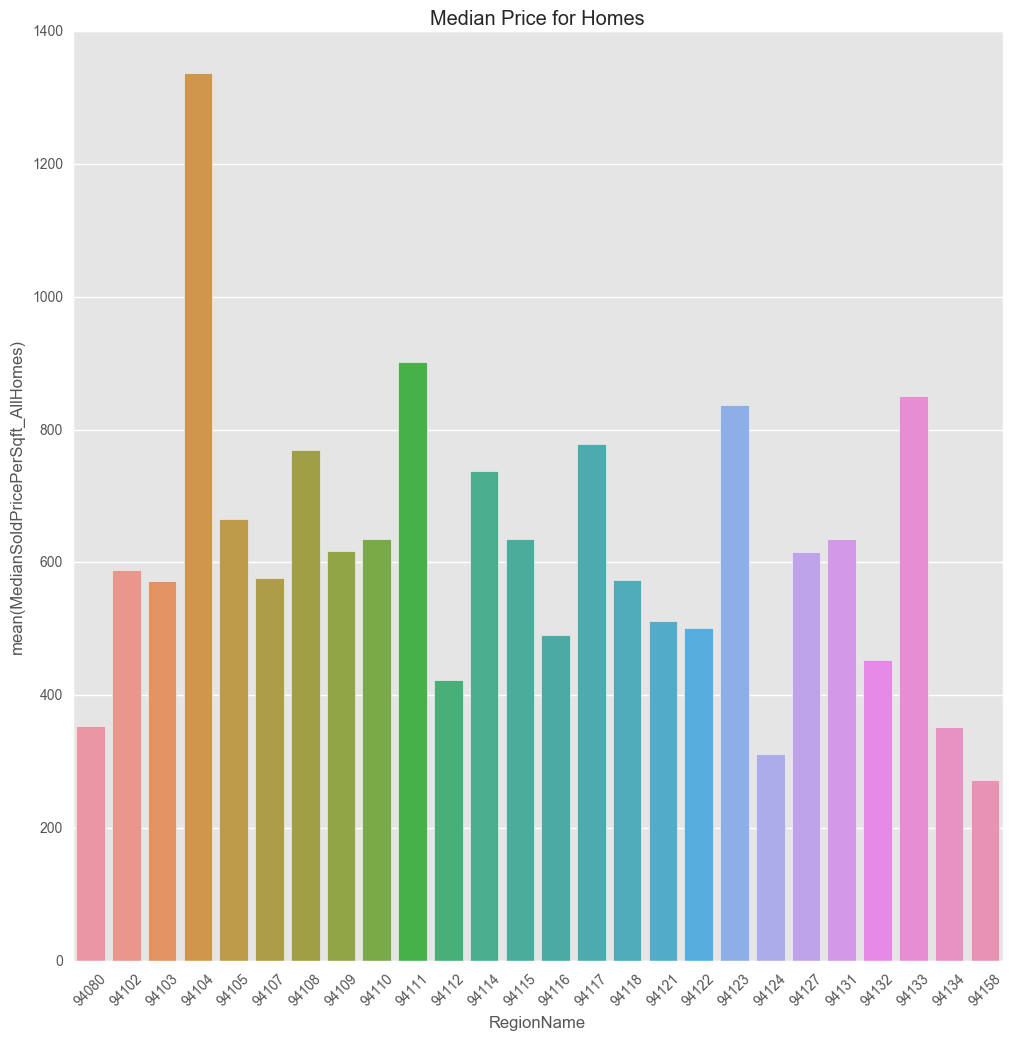

In [8]:
ppz = prices_per_zip.sort_values(by = "MedianSoldPricePerSqft_AllHomes", axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last') 

#PLOTTING
theplot = sns.barplot(x="RegionName", y="MedianSoldPricePerSqft_AllHomes", data=ppz,
            label="Total")

for item in theplot.get_xticklabels():
    item.set_rotation(45)

plt.title("Median Price for Homes")
plt.show()

In [9]:
prices_per_zip = pd.read_sql("SELECT RegionName, MedianSoldPricePerSqft_AllHomes FROM zillow \
WHERE MedianSoldPricePerSqft_AllHomes>0 \
GROUP BY RegionName", db)
ppz = prices_per_zip.sort_values(by="MedianSoldPricePerSqft_AllHomes", ascending=False) #order
top3 = ppz.iloc[:3] #get top 3 (most expensive)
bottom3 = ppz.iloc[-3:] #get bottom 3 
df = top3.append(bottom3) #create df
df

,RegionName,MedianSoldPricePerSqft_AllHomes
3,94104,1336.128581
9,94111,901.804100
23,94133,850.666667
24,94134,351.758200
19,94124,312.412600
25,94158,273.033708


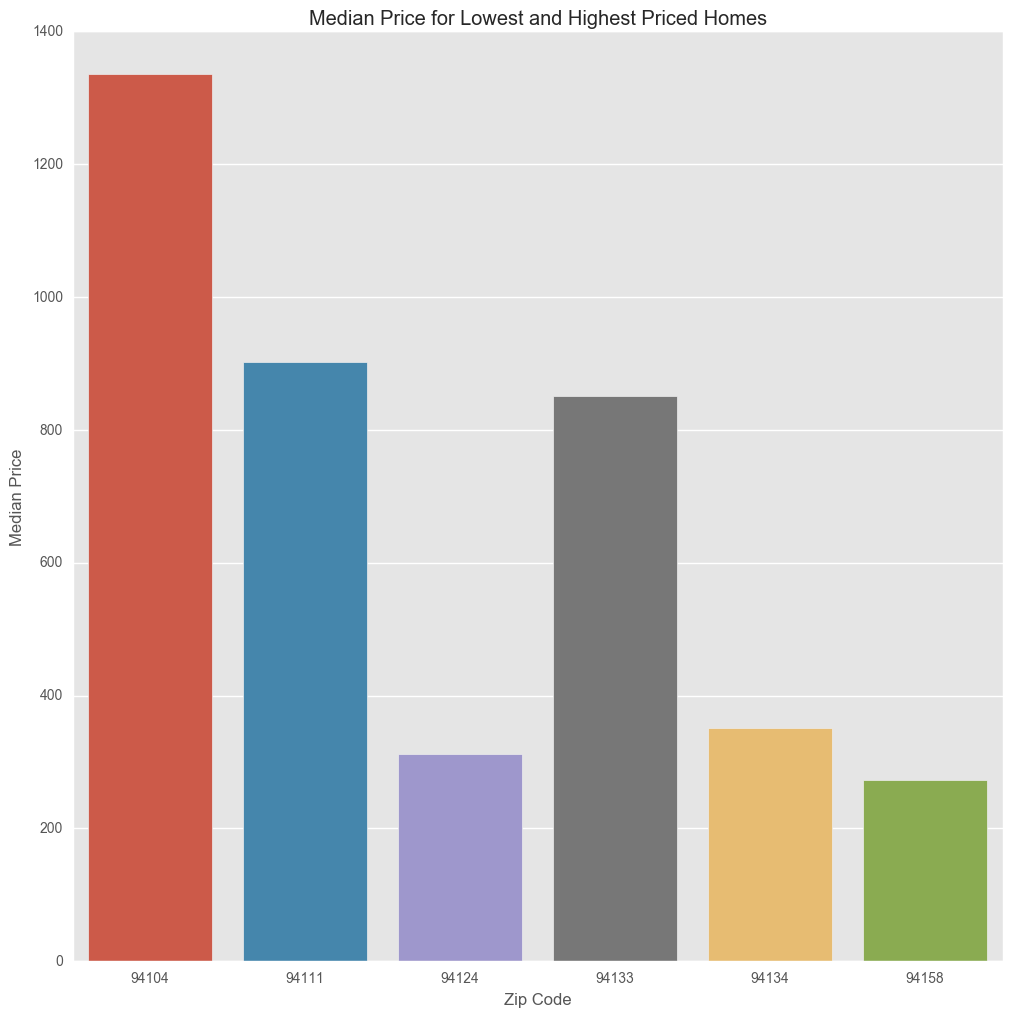

In [10]:
bottoms = sns.barplot(x="RegionName", y="MedianSoldPricePerSqft_AllHomes", data=df,
            label="Total")
plt.ylabel("Median Price")
plt.xlabel("Zip Code")
plt.title("Median Price for Lowest and Highest Priced Homes")
plt.show()

C:\Users\Niveditha_2\Anaconda2\lib\site-packages\geopandas\plotting.py:225: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  "(for consistency with matplotlib)", FutureWarning)


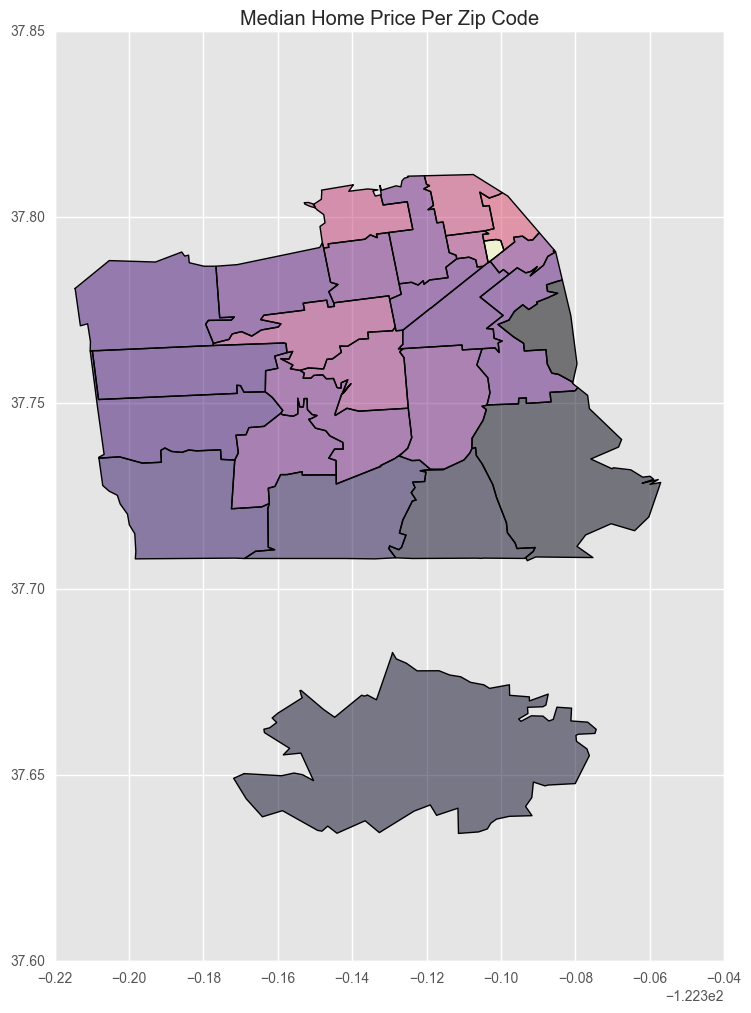

In [11]:
#Load zipcodes
zips = gpd.read_file("cb_2015_us_zcta510_500k/cb_2015_us_zcta510_500k.shp")
zips.head()

#Get zipcodes we want
zips = zips[zips.ZCTA5CE10.str.startswith("9")]
wanted = [str(x) for x in prices_per_zip["RegionName"].values]
zips = zips.loc[zips["ZCTA5CE10"].isin(set(wanted))]

#Add the zipcodes to the dataframe
zips["RegionName"] = zips["ZCTA5CE10"]
zips = zips.reset_index().sort_values(by="RegionName")

#Get relevant columns
zips = zips[["RegionName", "geometry"]].reset_index(drop=True)
prices_per_zip = prices_per_zip.reset_index(drop=True).sort_values(by="RegionName")

# prices_per_zip
#Create df to make a heatmap of median prices per zip
df_col_merged = pd.concat([zips, prices_per_zip["MedianSoldPricePerSqft_AllHomes"]], axis=1)
df_col_merged.head()
df_col_merged.plot(column='MedianSoldPricePerSqft_AllHomes', colormap="magma")
plt.title("Median Home Price Per Zip Code")
plt.show()

**Question 2: What can we learn from the visualization of the distribution of schools within San Francisco?**

**Observations:** The heat map shows us the distribution of schools within SF neighborhoods. The lighter colors indicate less occupation, and the darker colors indicate more. This is consistent with the layout of the city. We can see that areas such as Treasure Island (the little green island on the northeast corner of the map) and the more "wooded" parts have less schools. On the other hand, schools are highly concentrated in more populous neighborhoods, including downtown. The giant empty yellow area is Golden Gate Park and its surrounding areas, and the red parts are downtown/SoMa. At first, I was surprised to see a small yellow patch amidst all the red, and then realized it was the FiDi. 

To me, the overall visualization of the distribution of schools is retrospectively unsurprising after knowing the layout of San Francisco. It would be interesting to do a similar visual analysis on lesser-known cities to try to get an idea of their structural layout (i.e., we could potentially determine the geographical composition of a city by looking at the distribution of its schools). 

One more thing I noticed is that the entire Hunter's Point neighborhood is largely unconcentrated with schools. I know from my childhood that this is a generally unsafe neighborhood, and this motivates me to look at serious crimes with relation to (specifically private) schools. More on that later! 

In [12]:
us_zips=gpd.read_file("./cb_2015_us_zcta510_500k/cb_2015_us_zcta510_500k.shp")

In [13]:
#Find all the zipcodes within the school addresses (zips are 5 digit numbers, so we can use regex)
school_zips = np.array(["".join(re.findall("[0-9]{5}", s)) for s in pd.read_sql("SELECT Address FROM schools", db).Address.values], dtype="int64")

#Narrow down unique zipcodes
sf_zipcodes = us_zips[np.in1d(np.array(us_zips.GEOID10, dtype="int64"), np.unique(school_zips)) == True].reset_index(drop=True)

#sf_zipcodes

In [14]:
#Get latitude and longitude points for plotting
schpts=gpd.GeoDataFrame([geom.Point(tuple(xy)) for xy in pd.read_sql("SELECT Lon, Lat FROM schools",db).values],columns=["geometry"])

In [15]:
school_zip=sf_zipcodes.GEOID10[gpd.sjoin(schpts,sf_zipcodes,how="inner",op="within").index_right]

C:\Users\Niveditha_2\Anaconda2\lib\site-packages\geopandas\geodataframe.py:447: UserWarning: Invalid k: 94124 (2 <= k <= 9), setting k=5 (default)
  return plot_dataframe(self, *args, **kwargs)


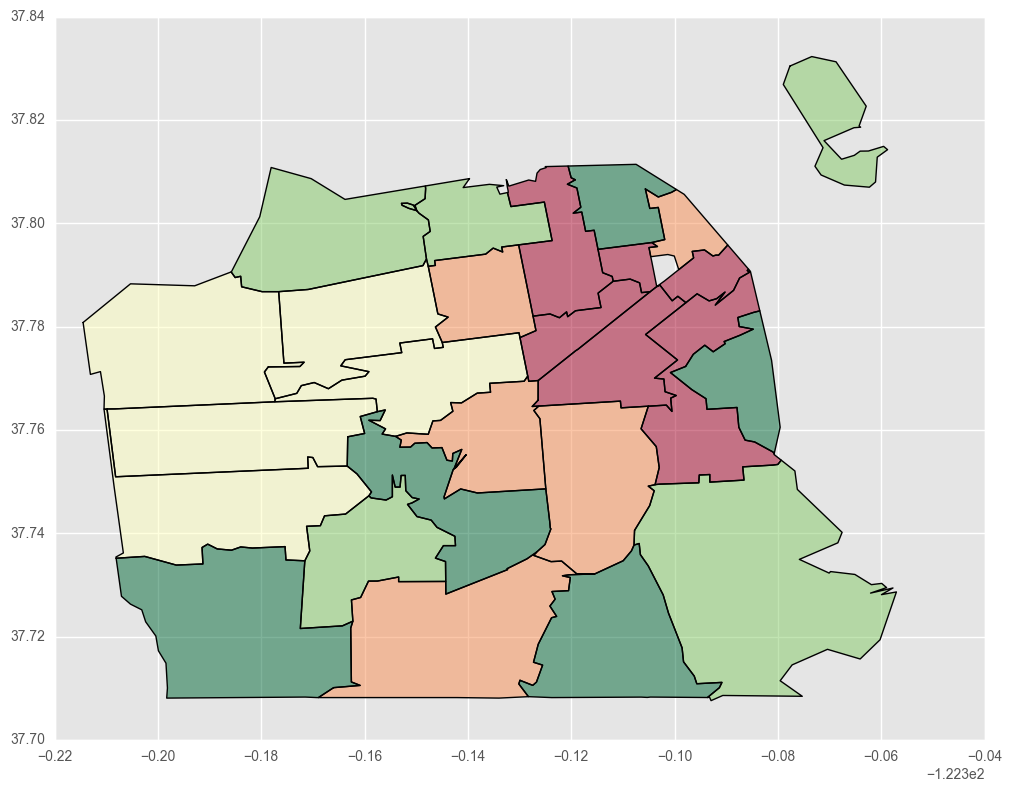

In [16]:
#Plot heatmap of schools with red being most concentrated 
sf_zipcodes.plot(column="ZCTA5CE10",cmap="RdYlGn",scheme="quantiles")

 **Question 3: Is there a visible difference between the number of private and public schools in general, and across neighborhoods?**
 
**Observations:** Surprisingly, to me, there seem to more private schools than public schools in San Francisco. Additionally, these private schools appear in clusters throughout the city, while public schools are more scattered. Despite a few differences, there do not seem to be clearly demarcated areas that are specific to these private school clusters. Even areas such as Treasure Island, the Bayview, and and specific districts known to be generally lower income have both private and public schools. 

Because the number of private and public schools first of all does not seem to be generally that different, and secondly does not seem to be reliant on neighborhood, I found it unnecessary to overlay it on a map of housing data. If there were more visible clusters within certain district lines, I would have wanted to see if higher occurences of private schools happened in higher income neighborhoods (i.e. neighborhoods with higher home prices) and examine other trends. Since this is not the case, we'll leave the plots as is.

In [17]:
#Query public and private school information
schools = pd.read_sql("SELECT * FROM schools WHERE Entity = 'Private' OR Entity = 'SFUSD'", db)

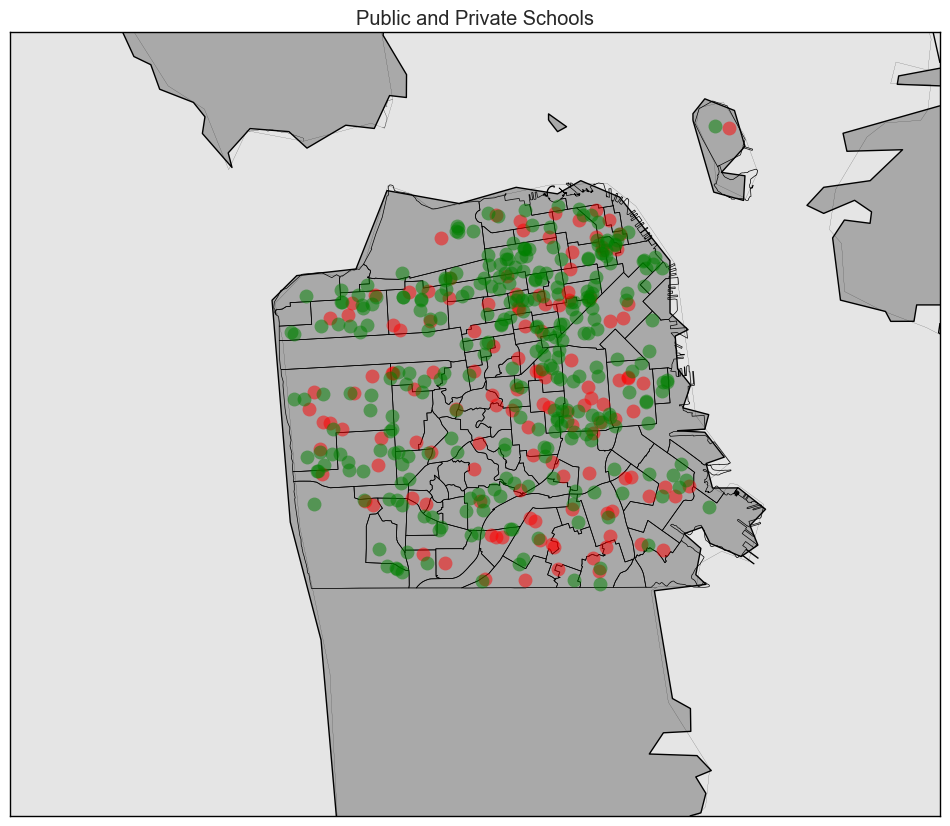

In [18]:
#Initialize basemap
school_map = Basemap(projection="merc", llcrnrlon=-122.6, llcrnrlat=37.65, urcrnrlon=-122.3, urcrnrlat=37.85, resolution="h", area_thresh = 0.1)

#Draw in lines, specify shapefile, and recolor
school_map.drawcoastlines()
school_map.drawmapboundary()
school_map.drawcounties()
school_map.readshapefile("sf/geo_export_3f513e76-4ea3-432b-a76f-988c05417905", "geo_export_3f513e76-4ea3-432b-a76f-988c05417905")
school_map.fillcontinents(color="darkgrey")

#Add scatter points
for lon, lat, entity in zip(schools.Lon, schools.Lat, schools.Entity):
    x, y = school_map(lon, lat)
    
    #Make public schools red
    color = "r"
    
    #Make private schools green (the color of money)
    if entity == "Private":
        color = "g"

    #Specify plot parameters     
    school_map.plot(x, y, color + "o", markersize = 10, alpha = 0.5)

#Plot
plt.title("Public and Private Schools")
plt.show()

**Problem 4: Which districts have the most arrests? Does this relate to housing prices?**

**Observations:** We can see that the top 5 districts with booked arrests are Southern, Mission, Tenderloin, Northern, and Bayview. These show clear geographical overlap with the "cheapest" neighborhoods in terms of median selling price, and we can cross reference the price heat map in Problem 1 to verify this. 

Note that I chose to use "booked arrests" as my criteria for this, because in my opinion, it is a fair measure for the severity of crime. Since these police records contain records for all sorts of crimes from homicide to petty theft, I thought it was important to further classify crimes to look at them with districts. 

Ultimately, we can conclude that crime (especially booked arrests) relates to housing prices. Given more time, we can be more specific about specific types of crime, including house-specific robbery, to see how they are distributed around SF. 

In [19]:
#pd.read_sql("SELECT DISTINCT Resolution FROM crime", db) #Types of arrests
crimes = pd.read_sql("SELECT * FROM crime WHERE Resolution = 'ARREST, BOOKED'", db)
#crimes.head()

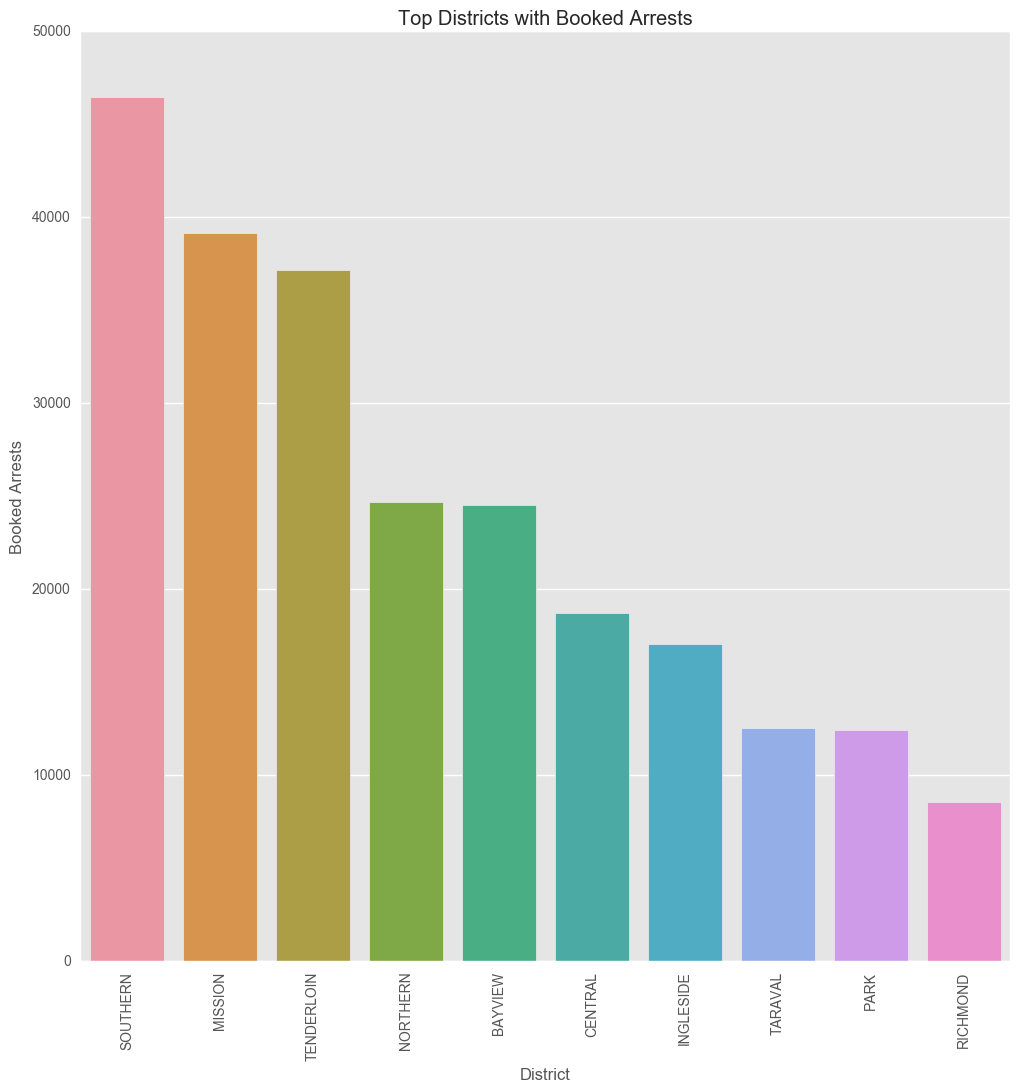

In [20]:
#Get booked arrests
arrests = crimes[crimes["Resolution"]=="ARREST, BOOKED"]
arrests_dist = pd.DataFrame(arrests["PdDistrict"].value_counts())

#Plot
plot = sns.barplot(x=arrests_dist.index.values[0:10], y=arrests_dist["PdDistrict"][0:10], data=arrests_dist,
            label="Total")
for item in plot.get_xticklabels():
    item.set_rotation(90)
plt.ylabel('Booked Arrests')
plt.xlabel('District')
plt.title("Top Districts with Booked Arrests")
plt.show()

**Question 5: How many instances of domestic violence go unresolved?**  

**Observations:** There have been over 9500 reported instances of domestic violences in SF since 2015. This is something I'm interested in from a legal perspective, so instead of choosing socioeconomic implications (such as to see if it relates to the neighborhood, house turnover ratio, etc.), I'm choosing to look at the actual outcome of a domestic violence report. In the pie chart below, there are three main categories that we care about. All the slices of the pie display how a domestic violence complaint has been resolved, and the three largest ones are "None", "Arrest, Booked", and "Complainant Refuses to Prosecute". 

Unfortunately, a majority (52.76%) of domestic violence reports in SF since 2015 have gone unprosecuted. There has been no arrest or recorded legal action according to these records. The second largest category shows the amount of arrests that have been made upon a domestic violence call, and it accounts for about 37.22% of total reports. This is by no means a majority, and it is interesting to note the two most prevalent outcomes.

We also have a smaller but still visible section of the pie that accounts for complainants who have refused to prosecute in a domestic violence case. This accounts for 5.92% of the total, and at some point in the future, I think it would be interesting to see if that 5.92% shares similar motivations or socioeconomic traits. This would most likely require something larger than a purely statistical analysis, but it might be a worthy undertaking to determine the effectiveness and prevalence of domestic violence prosecution, and ultimately glean the effects and characteristics of domestic violence on the home. 

In [21]:
#Query domestic violence information from crime table 
domestic = pd.read_sql("SELECT * \
FROM crime \
WHERE Descript LIKE '%DOMESTIC VIOLENCE%' \
ORDER BY PdDistrict", db)
domestic

,IncidntNum,Category,Descript,DayOfWeek,Datetime,PdDistrict,Resolution,Address,Lon,Lat
0,150098248,SECONDARY CODES,DOMESTIC VIOLENCE,Saturday,2015-01-31 21:00:00,BAYVIEW,NONE,700 Block of KIRKWOOD AV,-122.374019,37.729203
1,150098787,SECONDARY CODES,DOMESTIC VIOLENCE,Sunday,2015-02-01 18:17:00,BAYVIEW,NONE,BACON ST / HAMILTON ST,-122.409528,37.726085
2,150101396,SECONDARY CODES,DOMESTIC VIOLENCE,Monday,2015-02-02 10:00:00,BAYVIEW,"ARREST, BOOKED",1100 Block of PALOU AV,-122.382475,37.729263
3,150106528,SECONDARY CODES,DOMESTIC VIOLENCE,Wednesday,2015-02-04 05:55:00,BAYVIEW,NONE,6200 Block of 3RD ST,-122.395990,37.721313
4,150109613,SECONDARY CODES,DOMESTIC VIOLENCE,Tuesday,2015-02-03 17:00:00,BAYVIEW,NONE,0 Block of BAYVIEW ST,-122.393710,37.732739
5,150110949,SECONDARY CODES,DOMESTIC VIOLENCE,Thursday,2015-02-05 07:00:00,BAYVIEW,NONE,1000 Block of LECONTE AV,-122.398004,37.719033
6,150154787,SECONDARY CODES,DOMESTIC VIOLENCE,Thursday,2015-02-19 17:00:00,BAYVIEW,NONE,1100 Block of FITZGERALD AV,-122.390360,37.720506
7,150157587,SECONDARY CODES,DOMESTIC VIOLENCE,Thursday,2015-02-19 18:45:00,BAYVIEW,"ARREST, BOOKED",900 Block of INNES AV,-122.377184,37.732738
8,150158488,SECONDARY CODES,DOMESTIC VIOLENCE,Friday,2015-02-20 22:03:00,BAYVIEW,NONE,0 Block of GARLINGTON CT,-122.384397,37.732507
9,150160427,SECONDARY CODES,DOMESTIC VIOLENCE,Saturday,2015-02-21 13:44:00,BAYVIEW,NONE,EVANS AV / NAPOLEON ST,-122.396010,37.747262


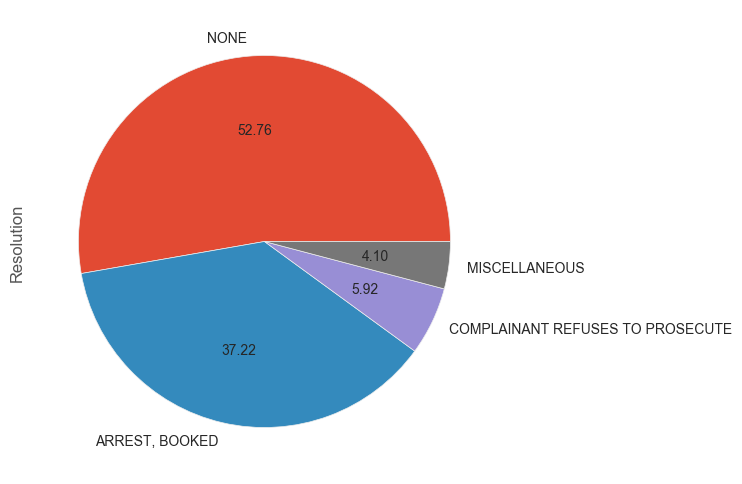

In [22]:
good_categories = np.in1d(domestic.Resolution.values,np.array(["NONE", "ARREST, BOOKED", "COMPLAINANT REFUSES TO PROSECUTE"]))
domestic.ix[good_categories == False, 'Resolution'] = "MISCELLANEOUS"
#Make pie plot for easy visualization
domestic.Resolution.value_counts().plot('pie', autopct='%.2f', fontsize=10, figsize=(6, 6))

In [ ]:
#Save this for future plotting
#sf_zipcodes.plot(column="",cmap="RdYlGn_r",scheme="quantiles")
#sf_zipcodes.plot(column="GEOID10",cmap="RdYlGn_r",scheme="quantiles")
#sf_zipcodes.plot()

In [23]:
db.close()

__Sources__: The general internet, *The Cohort*, and my friends (primarily For Loops and For Love: Graham, Edie, Chad; The Apartment of Statistics: Patrick, Graham) 